In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import timm
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def load_data(base_dir, img_height, img_width, batch_size):
    transform = transforms.Compose([
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    dataset = ImageFolder(base_dir, transform=transform)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    return train_loader, val_loader

base_dir = '/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'  # Replace with your dataset path
img_height, img_width = 224, 224
batch_size = 32
train_loader, val_loader = load_data(base_dir, img_height, img_width, batch_size)


In [4]:
def create_tnt_model(num_classes):
    model = timm.create_model('tnt_s_patch16_224', pretrained=True)
    model.head = torch.nn.Linear(model.head.in_features, num_classes)
    return model

num_classes = 4  # Change as per your dataset
model = create_tnt_model(num_classes)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


Epoch 1/50, Train Loss: 0.8976, Train Acc: 65.42%, Val Loss: 1.2010, Val Acc: 59.84%
Epoch 2/50, Train Loss: 0.5518, Train Acc: 80.06%, Val Loss: 0.2549, Val Acc: 92.17%
Epoch 3/50, Train Loss: 0.2318, Train Acc: 91.73%, Val Loss: 0.1830, Val Acc: 94.10%
Epoch 4/50, Train Loss: 0.1374, Train Acc: 95.56%, Val Loss: 0.1715, Val Acc: 93.61%
Epoch 5/50, Train Loss: 0.1130, Train Acc: 96.24%, Val Loss: 0.0673, Val Acc: 97.91%
Epoch 6/50, Train Loss: 0.0871, Train Acc: 97.28%, Val Loss: 0.1093, Val Acc: 96.22%
Epoch 7/50, Train Loss: 0.0795, Train Acc: 97.26%, Val Loss: 0.0357, Val Acc: 98.84%
Epoch 8/50, Train Loss: 0.1396, Train Acc: 95.32%, Val Loss: 0.2882, Val Acc: 91.53%
Epoch 9/50, Train Loss: 0.1631, Train Acc: 94.37%, Val Loss: 0.1227, Val Acc: 96.83%
Epoch 10/50, Train Loss: 0.1161, Train Acc: 95.97%, Val Loss: 0.0961, Val Acc: 97.31%
Epoch 11/50, Train Loss: 0.1136, Train Acc: 96.49%, Val Loss: 0.6203, Val Acc: 77.99%
Epoch 12/50, Train Loss: 0.1805, Train Acc: 93.94%, Val Loss: 0

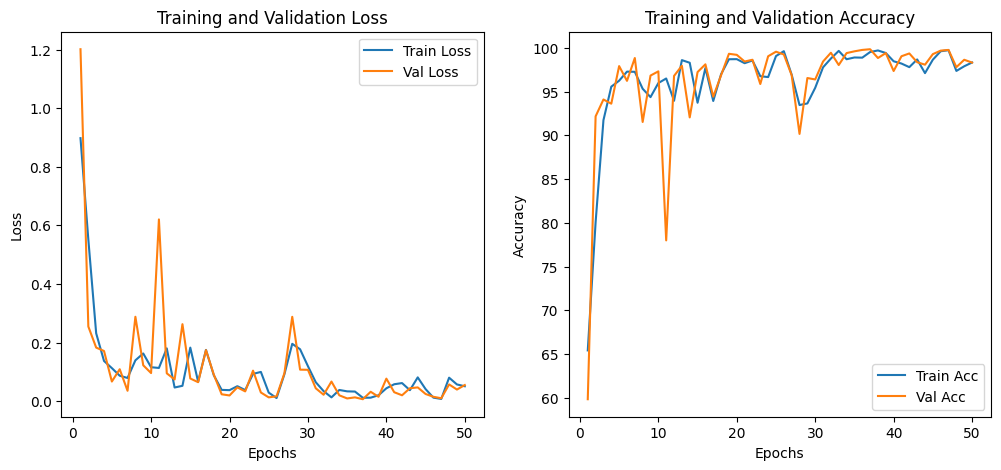

In [6]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=50):
    model = model.to(device)  # Move model to the correct device

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        # Training phase
        model.train()
        total_loss, correct, total = 0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the correct device
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(100 * correct / total)

        # Validation phase
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to the correct device
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct / total)

        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%')

    # Plotting the training and validation loss and accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Acc')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

train_model(model, criterion, optimizer, train_loader, val_loader)


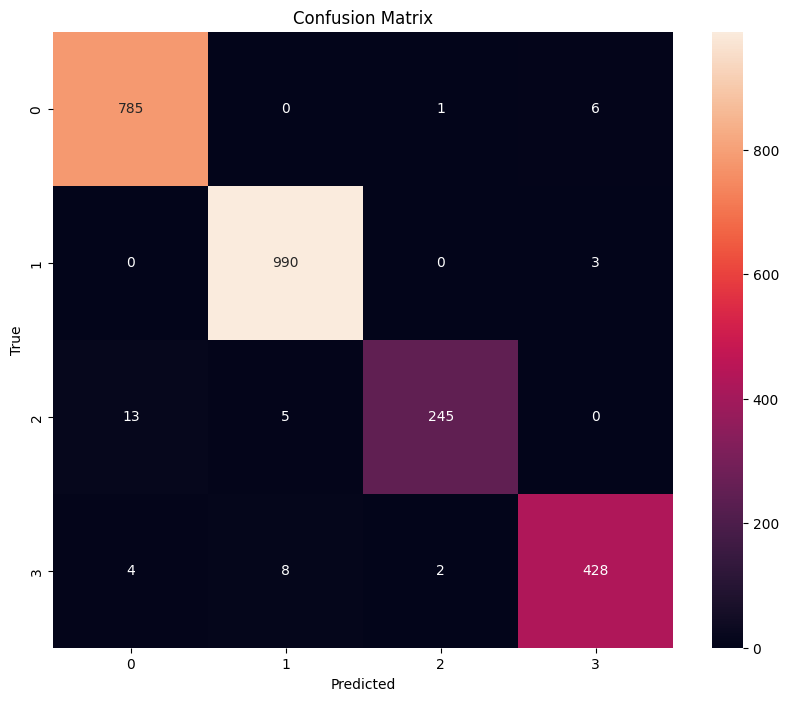

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       792
           1       0.99      1.00      0.99       993
           2       0.99      0.93      0.96       263
           3       0.98      0.97      0.97       442

    accuracy                           0.98      2490
   macro avg       0.98      0.97      0.98      2490
weighted avg       0.98      0.98      0.98      2490



In [7]:
def evaluate_model(model, val_loader):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.cuda()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()

    # Classification Report
    class_report = classification_report(all_labels, all_preds, output_dict=True)
    print(classification_report(all_labels, all_preds))
    report_df = pd.DataFrame(class_report).transpose()
    report_df.to_csv('classification_report.csv')

evaluate_model(model, val_loader)
